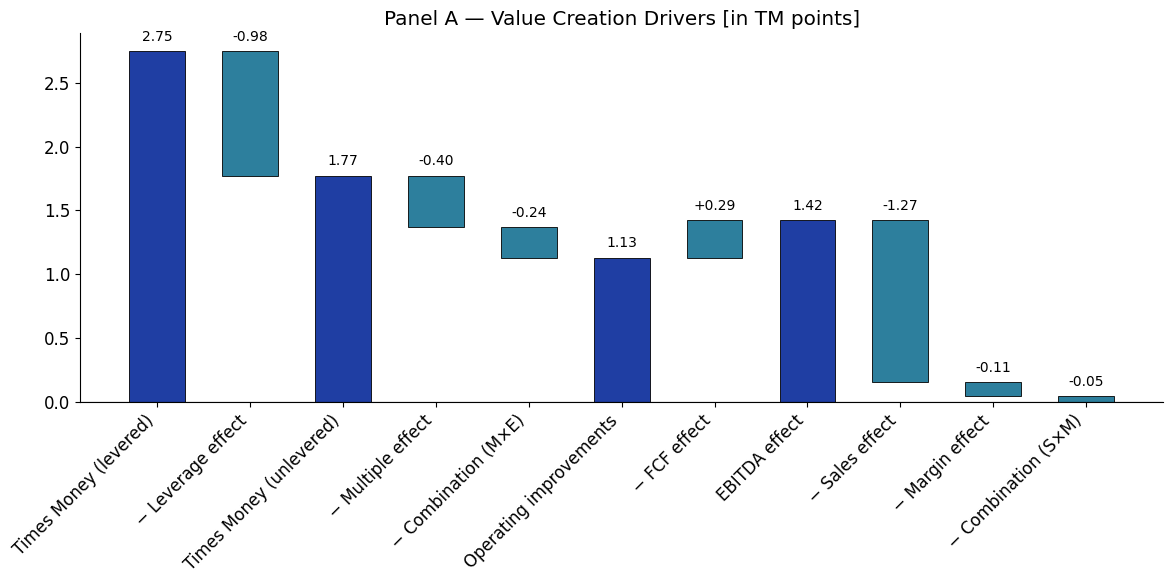

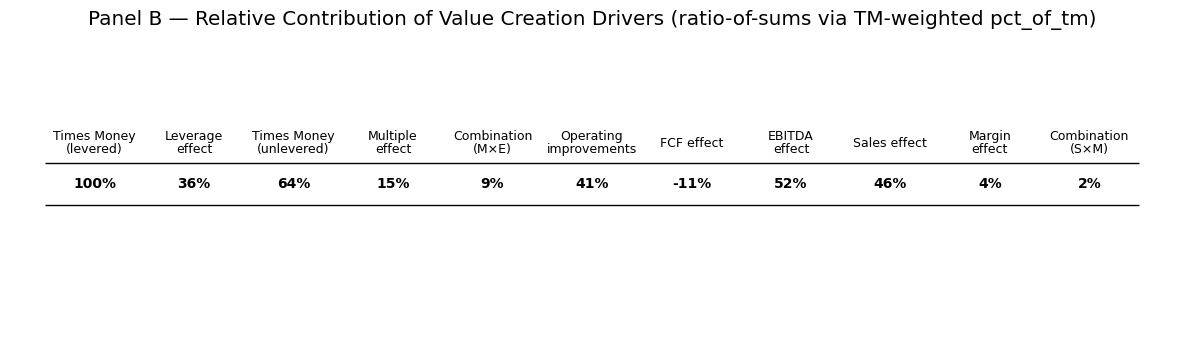

In [23]:
# === Analysis + Plots: TM-point means (Panel A) and ratio-of-sums (Panel B) ===

import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import textwrap

# ---- 1) Helpers (no global data mutation) ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels."
    )

# select-only; collapse to one row per deal
NUMERIC_COLS = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
    "pct_of_tm_multiple_effect",
    "pct_of_tm_multiple_ebitda_combination_effect",
    "pct_of_tm_fcf_effect",
    "pct_of_tm_ebitda_effect",
    "pct_of_tm_sales_effect",
    "pct_of_tm_margin_effect",
    "pct_of_tm_sales_margin_combination_effect",
]

def deal_view(df: pd.DataFrame) -> pd.DataFrame:
    missing = [c for c in NUMERIC_COLS if c not in df.columns]
    assert not missing, f"Missing expected columns: {missing}"
    # by construction these are per-deal duplicates; take first per deal_id
    return df.groupby("deal_id", as_index=False)[NUMERIC_COLS].first()

def panelA_means(D: pd.DataFrame) -> dict:
    """Return dict of TM, Lev, TMU and TMU-contrib means on the already prepared deal-view."""
    m = D[[
        "times_money","leverage_effect","tm_unlevered",
        "tmu_contrib_multiple_effect","tmu_contrib_multiple_ebitda_combination_effect",
        "tmu_contrib_fcf_effect","tmu_contrib_ebitda_effect",
        "tmu_contrib_sales_effect","tmu_contrib_margin_effect","tmu_contrib_sales_margin_combination_effect"
    ]].mean()
    return dict(
        tm   = m["times_money"],
        lev  = m["leverage_effect"],
        tmu  = m["tm_unlevered"],
        mult = m["tmu_contrib_multiple_effect"],
        comb = m["tmu_contrib_multiple_ebitda_combination_effect"],
        fcf  = m["tmu_contrib_fcf_effect"],
        ebit = m["tmu_contrib_ebitda_effect"],
        sale = m["tmu_contrib_sales_effect"],
        marg = m["tmu_contrib_margin_effect"],
        smc  = m["tmu_contrib_sales_margin_combination_effect"],
    )

def weighted_mean(values: pd.Series, weights: pd.Series) -> float:
    w = weights
    v = values
    den = float((w).sum())
    assert abs(den) > 1e-12, "Weighted mean denominator ~0 (sum of TM is ~0)."
    return float((v * w).sum() / den)

def panelB_from_pct(D: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    """
    Build Panel B from pct_of_tm_* (decimals), using TM-weighted averages.
    This equals the classical ratio-of-sums: sum(contrib)/sum(TM).
    Returns (panelB_ros, panelB_ros_robust), both in percent units.
    """
    tm = D["times_money"]
    # core atomics
    pct_mult = D["pct_of_tm_multiple_effect"]
    pct_comb = D["pct_of_tm_multiple_ebitda_combination_effect"]
    pct_fcf  = D["pct_of_tm_fcf_effect"]
    pct_ebit = D["pct_of_tm_ebitda_effect"]
    # sub-components
    pct_sale = D["pct_of_tm_sales_effect"]
    pct_marg = D["pct_of_tm_margin_effect"]
    pct_smc  = D["pct_of_tm_sales_margin_combination_effect"]

    # TM-weighted averages (→ ratio-of-sums), then convert to percent for display
    mult = weighted_mean(pct_mult, tm) * 100.0
    comb = weighted_mean(pct_comb, tm) * 100.0
    fcf  = weighted_mean(pct_fcf,  tm) * 100.0
    ebit = weighted_mean(pct_ebit, tm) * 100.0
    sale = weighted_mean(pct_sale, tm) * 100.0
    marg = weighted_mean(pct_marg, tm) * 100.0
    smc  = weighted_mean(pct_smc,  tm) * 100.0

    lev  = weighted_mean(D["leverage_effect"] / D["times_money"], tm) * 100.0
    tmu_pct = mult + comb + fcf + ebit  # equals TMU/TM * 100 by construction

    panelB_ros = pd.Series({
        "Times Money (levered)"  : 100.0,
        "Leverage effect"        : lev,
        "Times Money (unlevered)": tmu_pct,
        "Multiple effect"        : mult,
        "Combination (M×E)"      : comb,
        "Operating improvements" : fcf + ebit,
        "FCF effect"             : fcf,
        "EBITDA effect"          : ebit,
        "Sales effect"           : sale,
        "Margin effect"          : marg,
        "Combination (S×M)"      : smc,
    })

    # robust: exclude tiny-|TM| deals from percentages only
    eps = 0.05
    mask = tm.abs() >= eps
    tm_r = tm[mask]
    assert abs(float(tm_r.sum())) > 1e-12, "Robust denominator ~0."
    mult_r = weighted_mean(pct_mult[mask], tm_r) * 100.0
    comb_r = weighted_mean(pct_comb[mask], tm_r) * 100.0
    fcf_r  = weighted_mean(pct_fcf[mask],  tm_r) * 100.0
    ebit_r = weighted_mean(pct_ebit[mask], tm_r) * 100.0
    sale_r = weighted_mean(pct_sale[mask], tm_r) * 100.0
    marg_r = weighted_mean(pct_marg[mask], tm_r) * 100.0
    smc_r  = weighted_mean(pct_smc[mask],  tm_r) * 100.0
    lev_r  = weighted_mean((D["leverage_effect"]/D["times_money"])[mask], tm_r) * 100.0
    tmu_pct_r = mult_r + comb_r + fcf_r + ebit_r

    panelB_ros_robust = pd.Series({
        "Times Money (levered)"  : 100.0,
        "Leverage effect"        : lev_r,
        "Times Money (unlevered)": tmu_pct_r,
        "Multiple effect"        : mult_r,
        "Combination (M×E)"      : comb_r,
        "Operating improvements" : fcf_r + ebit_r,
        "FCF effect"             : fcf_r,
        "EBITDA effect"          : ebit_r,
        "Sales effect"           : sale_r,
        "Margin effect"          : marg_r,
        "Combination (S×M)"      : smc_r,
    })

    return panelB_ros, panelB_ros_robust

def chk_close(name, lhs, rhs, tol=1e-4):
    resid = float(lhs - rhs)
    if abs(resid) > tol:
        print(f"Warning: {name} off by {resid:+.6f} pp.")

# ---- 2) Visualization (sample filter allowed; no analysis beyond what helpers return) ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
df = pd.read_csv(TARGET_CSV)

# Keep the sample filter for debugging
#df = df.loc[df["deal_id"] == "111d1"].copy()
#assert not df.empty, "Sample deal_id '111d1' not found."
#assert df["deal_id"].nunique() == 1

# Collapse to deal-view (first transformation allowed here)
deal = deal_view(df)

# Panel A inputs (means on deal-view; no trimming here)
A = panelA_means(deal)
tm, lev, tmu = A["tm"], A["lev"], A["tmu"]
mult, comb, fcf, ebit, sale, marg, smc = A["mult"], A["comb"], A["fcf"], A["ebit"], A["sale"], A["marg"], A["smc"]
op = tmu - (mult + comb)

# Panel B from pct_of_tm_* using TM-weighted averages (equals ratio-of-sums)
panelB_ros, panelB_ros_robust = panelB_from_pct(deal)

# --- PANEL A: connected main bridge + single EBITDA drill-down
plt.rcParams.update({'font.size': 12})
figA, axA = plt.subplots(figsize=(12, 6))

MAIN_COLOR = "#1f3ea3"
STEP_COLOR = "#2d7f9d"

steps_main = [
    ("Times Money (levered)",      "start",    tm),
    ("− Leverage effect",          "delta",   -lev),
    ("Times Money (unlevered)",    "subtotal", None),
    ("− Multiple effect",          "delta",   -mult),
    ("− Combination (M×E)",        "delta",   -comb),
    ("Operating improvements",     "subtotal", None),
    ("− FCF effect",               "delta",   -fcf),
]
x_main = list(range(len(steps_main)))
prev = 0.0; bottoms=[]; heights=[]; labels=[]; kinds=[]; vals=[]; colors=[]
for lab, kind, val in steps_main:
    labels.append(lab); kinds.append(kind); vals.append(val)
    if kind == "start":
        bottoms.append(0.0); heights.append(val); prev = val; colors.append(MAIN_COLOR)
    elif kind == "delta":
        new = prev + val
        bottoms.append(min(prev, new)); heights.append(abs(val)); prev = new; colors.append(STEP_COLOR)
    else:  # subtotal
        bottoms.append(0.0); heights.append(prev); colors.append(MAIN_COLOR)

axA.bar(x_main, heights, bottom=bottoms, width=0.6, edgecolor="black", linewidth=0.6, color=colors)

ymin, ymax = axA.get_ylim()
offset = 0.02 * (ymax - ymin)
for xi, (kind, h, b, v) in enumerate(zip(kinds, heights, bottoms, vals)):
    top_edge = b + h
    txt = f"{h:.2f}" if kind in ("start","subtotal") else f"{v:+.2f}"
    axA.text(xi, top_edge + offset, txt, ha="center", va="bottom", fontsize=10)

# EBITDA drill-down
x0 = len(steps_main)
drill_labels = ["EBITDA effect","− Sales effect","− Margin effect","− Combination (S×M)"]
drill_kinds  = ["subtotal",     "delta",         "delta",          "delta"]
drill_vals   = [None,           -sale,           -marg,            -smc]

drill_bottoms = [0.0]; drill_heights = [ebit]; drill_colors = [MAIN_COLOR]
prev_e = ebit
for v in drill_vals[1:]:
    new_e = prev_e + v
    drill_bottoms.append(min(prev_e, new_e))
    drill_heights.append(abs(v))
    drill_colors.append(STEP_COLOR)
    prev_e = new_e

x_drill = list(range(x0, x0 + len(drill_labels)))
axA.bar(x_drill, drill_heights, bottom=drill_bottoms, width=0.6, edgecolor="black", linewidth=0.6, color=drill_colors)

for xi, (lab, kind, h, b, v) in enumerate(zip(drill_labels, drill_kinds, drill_heights, drill_bottoms, drill_vals)):
    xi_abs = x_drill[xi]
    top_edge = b + h
    txt = f"{h:.2f}" if kind == "subtotal" else f"{v:+.2f}"
    axA.text(xi_abs, top_edge + offset, txt, ha="center", va="bottom", fontsize=10)

axA.set_xticks(x_main + x_drill)
axA.set_xticklabels(labels + drill_labels, rotation=45, ha='right')
axA.set_title("Panel A — Value Creation Drivers [in TM points]")
axA.axhline(0, color='black', linewidth=0.8)
axA.spines['top'].set_visible(False)
axA.spines['right'].set_visible(False)

figA.tight_layout()
plt.show()

# ---- PANEL B figure (built from pct_of_tm_*; percent units) ----
headers = list(panelB_ros.index)
values  = [panelB_ros[h] for h in headers]

figB, axB = plt.subplots(figsize=(12, 3.6))
axB.set_axis_off()

n = len(headers)
left_margin, right_margin = 0.03, 0.97
xs = left_margin + (np.arange(n) + 0.5) * (right_margin - left_margin) / n

y_sep1 = 0.57
y_sep2 = 0.43
y_header = y_sep1 + 0.065
y_value  = 0.50

wrap_w = 12
for x, hdr, val in zip(xs, headers, values):
    axB.text(x, y_header, textwrap.fill(hdr, width=wrap_w),
             ha="center", va="center", fontsize=9, linespacing=1.05, transform=axB.transAxes)
    axB.text(x, y_value, f"{val:.0f}%", ha="center", va="center",
             fontsize=10, fontweight="bold", transform=axB.transAxes)

axB.hlines([y_sep1, y_sep2], xmin=left_margin, xmax=right_margin,
           colors="black", linewidth=1.0, transform=axB.transAxes)

axB.set_title("Panel B — Relative Contribution of Value Creation Drivers (ratio-of-sums via TM-weighted pct_of_tm)", pad=6)

figB.tight_layout()
plt.show()

# ---- 3) QA (condensed; no mutations) ----
def qa_panelB_hierarchy(series, label_prefix=""):
    # Level 0
    sum_atomic_all = series[["Leverage effect","Multiple effect","Combination (M×E)","FCF effect","EBITDA effect"]].sum()
    chk_close(f"{label_prefix}Level 0 (Lev + atomics vs 100%)", sum_atomic_all, 100.0)
    # Level 1
    sum_tmu_components = series["Multiple effect"] + series["Combination (M×E)"] + series["FCF effect"] + series["EBITDA effect"]
    chk_close(f"{label_prefix}Level 1 (components vs TMU)", sum_tmu_components, series["Times Money (unlevered)"])
    # Level 2
    sum_ebitda_sub = series["Sales effect"] + series["Margin effect"] + series["Combination (S×M)"]
    chk_close(f"{label_prefix}Level 2 (sales+margin+S×M vs EBITDA)", sum_ebitda_sub, series["EBITDA effect"])

qa_panelB_hierarchy(panelB_ros, label_prefix="")
qa_panelB_hierarchy(panelB_ros_robust, label_prefix="ROBUST ")


In [24]:
# === Stats: sample, entry-only, exit-only averages for key metrics ===
from pathlib import Path
import pandas as pd
import numpy as np

# ---- helper: locate repo root ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.\n"
        f"- Current working directory: {here}\n"
        f"- Checked: {[str((p / rel_path)) for p in [here, *here.parents][: max_up + 1]]}"
    )

TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")

# ---- load fresh ----
g = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})

# ---- guards ----
assert g.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."
assert "reference_date" in g.columns, "Missing 'reference_date' to determine entry/exit."

# ---- identify entry/exit rows per deal (earliest = entry, latest = exit) ----
ref = pd.to_datetime(g["reference_date"], errors="coerce")
rank = ref.groupby(g["deal_id"]).rank(method="first", ascending=True)
is_entry = rank.eq(1)
is_exit  = rank.eq(rank.groupby(g["deal_id"]).transform("max"))

# ---- metrics ----
metrics = [
    "net_debt",
    "ebitda_margin",
    "xebitda",
    "de_ratio",
    "dividends",
    "capital_injections",
    "interest_rate",
    "holding_period",
    "cost_of_debt",
]

def to_num(s): return pd.to_numeric(s, errors="coerce")

rows = []
for m in metrics:
    if m not in g.columns:
        rows.append({
            "metric": m,
            "sample_avg": np.nan,
            "entry_avg":  np.nan,
            "exit_avg":   np.nan,
            "n_deals_sample": 0,
            "n_deals_entry":  0,
            "n_deals_exit":   0,
        })
        continue

    x_all   = to_num(g[m])

    # per-deal mean across available rows (handles occasional NaNs per row)
    per_deal = x_all.groupby(g["deal_id"]).mean()
    sample_avg = per_deal.mean(skipna=True)
    n_deals_sample = int(per_deal.notna().sum())

    # entry-only and exit-only (one value per deal)
    x_entry = to_num(g.loc[is_entry, m]).groupby(g.loc[is_entry, "deal_id"]).first()
    x_exit  = to_num(g.loc[is_exit,  m]).groupby(g.loc[is_exit,  "deal_id"]).first()

    entry_avg = x_entry.mean(skipna=True)
    exit_avg  = x_exit.mean(skipna=True)

    rows.append({
        "metric": m,
        "sample_avg": float(sample_avg) if pd.notna(sample_avg) else np.nan,
        "entry_avg":  float(entry_avg)  if pd.notna(entry_avg)  else np.nan,
        "exit_avg":   float(exit_avg)   if pd.notna(exit_avg)   else np.nan,
        "n_deals_sample": int(n_deals_sample),
        "n_deals_entry":  int(x_entry.notna().sum()),
        "n_deals_exit":   int(x_exit.notna().sum()),
    })

stats = pd.DataFrame(rows).set_index("metric")

# ---- print ----
print("Averages by metric (per-deal means):")
print(stats[["sample_avg","entry_avg","exit_avg"]].round(6).to_string())

#print("\nDeal counts used per metric:")
#print(stats[["n_deals_sample","n_deals_entry","n_deals_exit"]].to_string())

g = pd.read_csv(TARGET_CSV, dtype={"deal_id": str})
by_status = (g.drop_duplicates(["deal_id","holding_status"])
               .groupby("holding_status")["deal_id"].nunique())
print(
    "unique_deals_exited:",   int(by_status.get("exited", 0)),
    "unique_deals_unexited:", int(by_status.get("unexited", 0)),
    "unique_deals_total:",    g["deal_id"].nunique()
)
# === Ownership % coverage summary (counts per deal) ===
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")

df = pd.read_csv(TARGET_CSV, dtype={"deal_id": str})

# guard: exactly 2 rows per deal at this stage
rows_per_deal = df.groupby("deal_id")["deal_id"].size()
assert (rows_per_deal == 2).all(), "Each deal_id must have exactly 2 rows (entry + exit)."

# count non-null ownership values per deal (0, 1, or 2)
k = (df["ownership_economic_percentage"].notna()
     .groupby(df["deal_id"])
     .sum())  # boolean sum → 0/1/2

both_present = int((k == 2).sum())   # one value at entry AND one at exit
one_only     = int((k == 1).sum())   # exactly one of entry/exit present
none_present = int((k == 0).sum())   # neither entry nor exit present
total_deals  = int(k.shape[0])

print("Ownership coverage (deal_id counts):",
      {"both_entry_and_exit": both_present,
       "exactly_one_of_entry_or_exit": one_only,
       "none": none_present,
       "total_deals": total_deals})


Averages by metric (per-deal means):
                      sample_avg     entry_avg      exit_avg
metric                                                      
net_debt            4.311459e+08  3.607733e+08  5.015184e+08
ebitda_margin       2.433230e-01  2.419160e-01  2.447300e-01
xebitda             1.572447e+01  1.391794e+01  1.753101e+01
de_ratio            8.063040e-01  9.918040e-01  6.208040e-01
dividends           1.346814e+02  1.346814e+02  1.346814e+02
capital_injections -1.346814e+02 -1.346814e+02 -1.346814e+02
interest_rate       4.208800e-02  4.208800e-02  4.208800e-02
holding_period      4.927059e+00  4.927059e+00  4.927059e+00
cost_of_debt        2.310280e-01  2.310280e-01  2.310280e-01
unique_deals_exited: 157 unique_deals_unexited: 111 unique_deals_total: 268
Ownership coverage (deal_id counts): {'both_entry_and_exit': 172, 'exactly_one_of_entry_or_exit': 48, 'none': 48, 'total_deals': 268}
